# Práctica 2: Procesamiento del Lenguaje Natural

__Fecha de entrega: 3 de abril de 2022__

El objetivo de esta práctica es aplicar los conceptos teóricos vistos en clase en el módulo de PLN. La práctica consta de 2 notebooks que se entregarán simultáneamente en la tarea de entrega habilitada en el Campus  Virtual.

Lo más importante en esta práctica no es el código Python, sino el análisis de los datos y modelos que construyas y las explicaciones razonadas de cada una de las decisiones que tomes. __No se valorarán trozos de código o gráficas sin ningún tipo de contexto o explicación__.

Finalmente, recuerda establecer el parámetro `random_state` en todas las funciones que tomen decisiones aleatorias para que los resultados sean reproducibles (los resultados no varíen entre ejecuciones).

In [9]:
RANDOM_STATE = 57

# Apartado 1: Clasificador de noticias

## 1) Carga del conjunto de datos

El fichero `BBC News.csv` contiene noticias clasificadas en 5 categorías diferentes. 

Carga los datos en un dataframe teniendo en cuenta que la columna `ArticleId` es un identificador de la noticia y por lo tanto no debes usarlo para clasificar. 

Estudia el tamaño del conjunto de datos y la proporción de noticias que pertenecen a cada una de las categorías. Indica si debemos tenerlo en cuenta de alguna forma al analizar los modelos que construyamos.

Muestra un mensaje cualquiera y explica si lo habrías clasificado en la clase correcta tras leerlo.

Crea una partición de los datos dejando el 80% para entrenamiento y el 20% restante para test usando la función `train_test_split` de sklearn. 

In [8]:
import pandas as pd
import numpy as np

In [3]:
df = pd.read_csv("BBC News.csv", index_col = 0)
df

,Text,Category
ArticleId,,
1833,worldcom ex-boss launches defence lawyers defe...,business
154,german business confidence slides german busin...,business
1101,bbc poll indicates economic gloom citizens in ...,business
1976,lifestyle governs mobile choice faster bett...,tech
917,enron bosses in $168m payout eighteen former e...,business
...,...,...
857,double eviction from big brother model caprice...,entertainment
325,dj double act revamp chart show dj duo jk and ...,entertainment
1590,weak dollar hits reuters revenues at media gro...,business


In [4]:
df['Category'].value_counts()

sport            346
business         336
politics         274
entertainment    273
tech             261
Name: Category, dtype: int64

<AxesSubplot:ylabel='Category'>

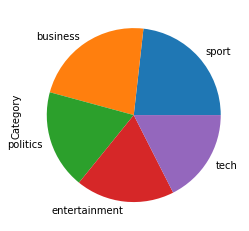

In [5]:
df['Category'].value_counts().plot.pie()

Analizando el diagrama de sectores de arriba vemos que hay dos categorías más frecuentes que el resto, sport y business. Sin embargo no es muy amplia la diferencia con el resto de categorías, que están en torno a las 270, mientras que las dos principales oscilan entre 330. 
Vemos también que la diferencia entre la mas frecuente y la que menos supera ligeramente las 80 noticias. Nos sorprende como en un medio serio como la BBC se hable más de deportes que de política o economía.

En este caso no tendremos en cuenta la diferencia de noticias de un tipo u otro ya que, al ser una diferencia pequeña no creemos que afecte a la hora de clasificar textos.

In [6]:
df_aux = df[35:36]
df_aux.values

array([['musical treatment for capra film the classic film it s a wonderful life is to be turned into a musical by the producer of the controversial hit show jerry springer - the opera.  frank capra s 1946 movie starring james stewart  is being turned into a £7m musical by producer jon thoday. he is working with steve brown  who wrote the award-winning musical spend spend spend. a spokeswoman said the plans were in the  very early stages   with no cast  opening date or theatre announced.  a series of workshops have been held in london  and on wednesday a cast of singers unveiled the musical to a select group of potential investors. mr thoday said the idea of turning the film into a musical had been an ambition of his for almost 20 years. it s a wonderful life was based on a short story  the greatest gift  by philip van doren stern. mr thoday managed to buy the rights to the story from van doren stern s family in 1999  following mr brown s success with spend spend spend. he later secure

Viendo este mensaje, antes de leer la categoría a la que pertenece, sí hemos logrado anticipar que pertenecía a la categoría de entretenimiento, ya que habla de un gran clásico como "¡Que bello es vivir!", protagonizada por el más grande aún James Stewart, actor de películas como "Vertigo" y "El hombre que mató a Liberty Valance".

Vamos a probar otro mensaje al azar.

In [27]:
import random

n = random.randint(1, 1490) # 1009
df_aux = df[n:n+1]
df_aux.values

array([['howard unveils election platform the conservatives would stand up for the  forgotten majority   michael howard pledged as he unveiled the first part of the tory election manifesto.  the tory leader argued there was a mass of people whom he says feel let down by tony blair and who share tory values. in the foreword to the manifesto  he promises to focus on restoring order  trying to lower taxes and giving power back to the people. labour says the document offers only a return to a  failed tory past . the liberal democrats say the conservatives cannot win what they predict will be a three-party contest.  campaigning activity is accelerating ahead of the general election  which is widely tipped for may but could be any time before june 2006. labour on monday postponed a launch of election posters because of the asian tsunami disaster. mr howard published the introduction to the tory manifesto. other chapters will follow in coming weeks.  in a speech in northamptonshire  he said t

En esta ocasión vemos que claramente se trata de una noticia relacionada con política, al mencionar palabras como: election, conservatives, tony blair, taxes, liberal democrats...
Algunas palabras podrían pertenecer también a noticias de economía, como taxes. Sin embargo el amplio números de palabras que pertenecerían exclusivamente a noticias de política supera a aquellas que pueden resultar ambiguas. En este mensaje palabras como election o democrats parecen ser decisivas para determinar la categoría a la que pertenecen.

In [10]:
from sklearn.model_selection import train_test_split

In [104]:
X_train, X_test, y_train, y_test = train_test_split(df['Text'].values, df['Category'].values, test_size=0.2, random_state=RANDOM_STATE)
train_len = len(X_train)
test_len = len(X_test)
(train_len, test_len)

(1192, 298)

Tras la separación de datos para los conjutos de entrenamiento y test, 1192 se usarán para el entrenamiento y los 298 restantes los usaremos para el conjunto de test.

## 2) Representación basada en bolsa de palabras y frecuencia de aparición

La primera vectorización que vamos a usar representará los mensajes usando el modelo de bolsa de palabras, monogramas y la frecuencia de aparición de cada palabra. Usa como _stop words_ las que vienen configuradas por defecto para el inglés.

Aplica la vectorización a los conjuntos de mensajes de entrenamiento y test. Muestra algún mensaje tanto en su formato de texto original como en la versión vectorizada. ¿Qué palabras se han eliminado y por qué?

Entrena un clasificador Naive Bayes Multinomial y calcula su tasa de aciertos sobre el conjunto de entrenamiento y el conjunto de test. A continuación calcula los valores de precisión, exhaustividad y puntuación F1 para cada una de las clases. Dibuja la matriz de confusión. Analiza los resultados obtenidos.

A continuación, entrena un clasificador k-NN con la configuración por defecto y usando la misma vectorización. Analiza los resultados, ¿a qué crees que se deben?

In [105]:
from sklearn.feature_extraction.text import CountVectorizer

In [106]:
vectorizer = CountVectorizer(stop_words='english', binary=False, ngram_range=(1,1)) 

In [107]:
train_vector_data=vectorizer.fit_transform(X_train)

# Extraemos las palabras de nuestro vector de palabras
feature_names = vectorizer.get_feature_names()
print(len(feature_names))

22249


El vocabulario dispone de 22.249 palabras.
A continuación vamos a extraer algunas de esas palabras para ver cuáles son.

In [12]:
print(train_vector_data[10])

  (0, 17428)	5
  (0, 9847)	1
  (0, 21985)	1
  (0, 19287)	1
  (0, 18062)	1
  (0, 12209)	1
  (0, 13424)	4
  (0, 12045)	2
  (0, 22136)	2
  (0, 10467)	1
  (0, 9264)	1
  (0, 17196)	1
  (0, 8174)	14
  (0, 13403)	1
  (0, 2361)	7
  (0, 2853)	10
  (0, 1248)	3
  (0, 13308)	1
  (0, 6655)	1
  (0, 9123)	3
  (0, 14908)	1
  (0, 15605)	1
  (0, 21470)	1
  (0, 6678)	1
  (0, 21858)	2
  :	:
  (0, 3974)	1
  (0, 9365)	1
  (0, 5480)	1
  (0, 3296)	2
  (0, 16841)	1
  (0, 7845)	1
  (0, 18986)	1
  (0, 1233)	1
  (0, 3946)	1
  (0, 12685)	1
  (0, 7411)	1
  (0, 2358)	1
  (0, 11847)	1
  (0, 5780)	2
  (0, 18144)	1
  (0, 9608)	1
  (0, 15362)	1
  (0, 15584)	1
  (0, 2377)	1
  (0, 12271)	1
  (0, 18470)	1
  (0, 20579)	1
  (0, 4219)	1
  (0, 21886)	1
  (0, 10060)	1


In [13]:
print(feature_names[:50])
print(feature_names[5000:5020])
print(feature_names[-20:])

['00', '000', '0001', '000bn', '000m', '000th', '001', '001and', '001st', '0051', '01', '0100', '0130', '028', '03', '033', '04', '0400', '04bn', '04secs', '05', '050505', '0530gmt', '056', '05bn', '05m', '06', '069', '07', '070', '0710', '072', '0730', '08', '080', '0800', '0845', '0870', '088', '09', '0900', '093', '0950', '09bn', '09secs', '10', '100', '1000m', '100bn', '100m']
['consecutive', 'consecutively', 'conseil', 'consensus', 'consent', 'consenus', 'consequences', 'consequently', 'conservationists', 'conservative', 'conservatively', 'conservatives', 'conserve', 'consider', 'considerable', 'considerably', 'consideration', 'considerations', 'considered', 'considering']
['zillion', 'zimbabwe', 'zinc', 'zinedine', 'ziyi', 'zodiac', 'zoe', 'zoellick', 'zola', 'zombie', 'zombies', 'zone', 'zonealarm', 'zones', 'zoom', 'zooms', 'zooropa', 'zurich', 'zutons', 'zvonareva']


Vemos que en las primeras 50 palabras, por ejemplo, hay algunos valores númericos extraños como "000m" o "0001", que son considerados como ruido. Aunque sean pocas palabras, las eliminaremos para que no haya interferencia en el análisis. 

In [108]:
vectorizer = CountVectorizer(stop_words='english', binary=False, ngram_range=(1,1), token_pattern=r'(?u)\b[A-Za-z]+\b') 

train_vector_data=vectorizer.fit_transform(X_train)

feature_names = vectorizer.get_feature_names()
print(len(feature_names))

21183


Se han descartado unas 1000 palabras, que no son muchas en comparación con las que había originalmente (5%), por lo que no habrá mucha variación entre los datos originales y su versión vectorizada y reducida. 

In [15]:
print(feature_names[:50])
print(feature_names[5000:5020])
print(feature_names[-20:])

['aa', 'aaa', 'aaas', 'aac', 'aadc', 'aaliyah', 'aaltra', 'aamir', 'aaron', 'abacus', 'abandon', 'abandoned', 'abandoning', 'abandonment', 'abating', 'abba', 'abbas', 'abbasi', 'abbott', 'abbreviated', 'abc', 'abdellatif', 'abdication', 'abdomen', 'abdominal', 'abducted', 'abduction', 'abdullah', 'abdullatif', 'abebe', 'aberdeen', 'aberration', 'aberystwyth', 'abeyie', 'abhorrent', 'abide', 'abided', 'abiding', 'abigail', 'abilities', 'ability', 'abish', 'able', 'abn', 'abnormal', 'abnormality', 'abolish', 'abolishing', 'abolition', 'aborted']
['dems', 'den', 'dench', 'denial', 'denials', 'denied', 'denies', 'denis', 'denise', 'denmark', 'dennis', 'denominated', 'densely', 'dent', 'dental', 'dented', 'deny', 'denying', 'denzel', 'deodorant']
['zillion', 'zimbabwe', 'zinc', 'zinedine', 'ziyi', 'zodiac', 'zoe', 'zoellick', 'zola', 'zombie', 'zombies', 'zone', 'zonealarm', 'zones', 'zoom', 'zooms', 'zooropa', 'zurich', 'zutons', 'zvonareva']


Vemos que los números que hemos mencionado antes ya no aparecen, aunque creemos que palabras como "04secs", por ejemplo, tienen  sentido y aún así se han borrado. En el caso contrario, vemos que palabras como por ejemplo "aaa" se han mantenido y carecen de sentido.

Comprobamos que se han eliminado las palabras alfanuméricas, ya que, salvo algunas excepciones, provocan ruido y se han mantenido las palabras compuestas solo por letras, ya que apenas algunas de ellas no tienen sentido. 

A continuación mostramos un mensaje en su formato original y en su versión vectorizada.

In [109]:
import numpy.ma as ma

def write_terms (feature_names, data, vector_data, index):
    '''
    Escribe los términos presentes en un mensaje representado como bolsa de palabras.
    
    - feature_names: terminos usados para vectorizar
    - data: lista de mensajes original (si data==None no se muestra el mensaje original)
    - vector_data: matriz (dispersa) de mensaje vectorizados
    - index: posición del mensaje a mostrar
    '''
    #máscara para seleccionar sólo el mensaje en posición index
    mask=vector_data[index,:]>0
    
    # términos que aparecen en ese mensaje vectorizado
    terminos = ma.array(feature_names, mask = ~(mask[0].toarray()))
    
    # mostrar mensaje original
    if data is not None:
        print('Mensaje', index, ':', data[index], '\n')
    
    # mostrar términos que aparecen en el mensaje vectorizado
    print('Mensaje', index, 'vectorizado:', terminos.compressed(),'\n')

In [16]:
write_terms(feature_names, X_train, train_vector_data, 10)

Mensaje 10 : vera drake s bafta triumph hope at the bafta film awards on saturday night  there is the prospect that a home-grown movie could walk off with a clutch of trophies.  vera drake  mike leigh s tale about a 1950s backstreet abortionist  is nominated in 11 categories. these include best film  best director and best actress shortlist for imelda staunton who plays the eponymous character. the film has spent months being lauded with prizes  from the venice film festival to five awards from the london critics  circle on wednesday night.  the baftas has a tradition of honouring british cinema  and this year vera drake is the obvious candidate to be heaped with praise. empire magazine s reviews editor dan jolin said the film had  a very good chance  of doing well on saturday  predicting that it would collect five or six awards.  i don t think it s going to do a lord of the rings-style sweep  but imelda staunton is a shoo-in for best actress   he said.   a best director prize for mike

Vemos que se han elimidado palabras con números, como "1950s". También han desaparecido preposiciones "on" o "in", y palabras cortas como "if", "is" o "i". 

El primer caso vemos que coincide con lo que ya explicamos arriba de eliminar números, ya que podían causar ruido. En cuanto al resto, vemos que se han eliminado palabras de una o 2 letras que empiezan por vocal, ya que es más probable que causen ruido, aunque en este caso no sería así. Vemos también que este clase de palabras (de una o 2 letras) se han mantenido si empiezan por consonante, como es el caso de "t", "mr" o "s".

In [17]:
from sklearn.naive_bayes import MultinomialNB

In [18]:
len(y_train)

1192

In [110]:
test_vector_data=vectorizer.transform(X_test)


In [111]:
mnb_classifier = MultinomialNB()

mnb_classifier.fit(train_vector_data, y_train)

mnb_train_predictions = mnb_classifier.predict(train_vector_data)
mnb_test_predictions = mnb_classifier.predict(test_vector_data)

print("Multinomial Naive Bayes, porcentaje de aciertos en entrenamiento:", np.mean(mnb_train_predictions == y_train))
print("Multinomial Naive Bayes, porcentaje de aciertos en test:", np.mean(mnb_test_predictions == y_test))

Multinomial Naive Bayes, porcentaje de aciertos en entrenamiento: 0.99748322147651
Multinomial Naive Bayes, porcentaje de aciertos en test: 0.9765100671140939


Vemos con los valores resultantes de la celda anterior que nuestro modelo no ha sobreaprendido, ya que la diferencia del porcentaje de aciertos entre el conjunto de entrenamiento y el conjunto de test es de centésimas, y ambos muy cercanos a uno. 

In [112]:
from sklearn.metrics import classification_report, confusion_matrix

In [113]:
target_names = ['sport', 'business', 'politics', 'entertainment', 'tech']

In [114]:
classifier=mnb_classifier
predictions = mnb_test_predictions

print(classification_report(y_test, predictions, target_names=target_names))

               precision    recall  f1-score   support

        sport       0.96      1.00      0.98        70
     business       1.00      0.98      0.99        50
     politics       0.95      0.98      0.96        56
entertainment       1.00      0.97      0.99        78
         tech       0.98      0.93      0.95        44

     accuracy                           0.98       298
    macro avg       0.98      0.97      0.97       298
 weighted avg       0.98      0.98      0.98       298



(array([0.5, 1.5, 2.5, 3.5, 4.5]),
 [Text(0.5, 0, 'sport'),
  Text(1.5, 0, 'business'),
  Text(2.5, 0, 'politics'),
  Text(3.5, 0, 'entertainment'),
  Text(4.5, 0, 'tech')])

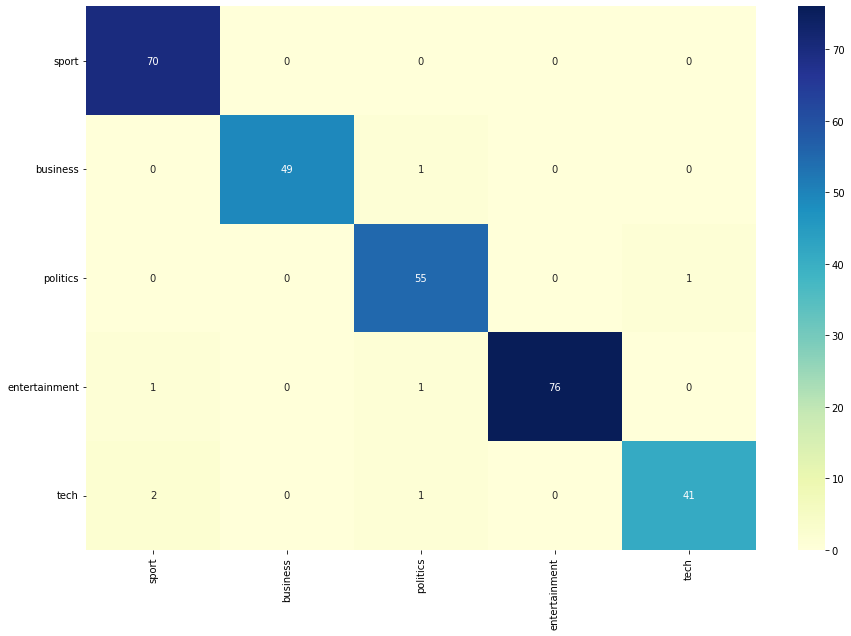

In [115]:
%matplotlib inline
import seaborn as sn
import matplotlib.pyplot as plt

conf_matrix = confusion_matrix(y_test, predictions)
conf_matrix_df = pd.DataFrame(conf_matrix, index=target_names, columns=target_names)

plt.figure(figsize=(15, 10))
sn.heatmap(conf_matrix_df, annot=True, vmin=0, vmax=conf_matrix.max(), fmt='d', cmap="YlGnBu")
plt.yticks(rotation=0)
plt.xticks(rotation=90)

En la tabla de arriba podemos ver como la clasificación por Naive Bayer tiene una precisión media de 0.98 y un recall medio de 0.97. Vemos también que la precisión es menor en políticas y deportes, y tiene valor 1 en entretenimiento y negocios. En cuanto al recall,  vemos que alcanza valor 1 en deportes. El valor mínimo se distancia de los obtenidos hasta ahora, siendo 0.93 para las noticias de temática tecnológica. Para poder ver que noticias identificaría mejor, estudiamos el valor f1, que engloba los 2 valores ya estudiados. En este valor vemos que los valores máximos se corresponden a las noticias de negocios y entretenimiento, y el mínimo, a tecnología. 

Este análisis nos da a entender que las noticias mejor reconocidas son las que tienen mayores valores f1. En este caso son las de negocios y entretenimiento, seguidas por deportes, políticas y, por último, tecnología. 

Para ver en cómo se ha equivocado este clasificador vamos a estudiar la matriz de confusión. 

En la matriz, vemos como efectivamente las noticias mejor clasificadas son negocios y entretenimiento, ya que todas las que el clasificador ha predicho que son de ese tipo lo son. Vemos también que solo unas pocas (1 en business y 2 en entretenimiento) han sido predichas como algo distinto a lo que son. En el caso de business, ha sido confundida con política, lo cual tiene sentido ya que ambos son temas relacionados y pueden tener palabras en común, como las intenciones de un político frente a estos temas o como estas intenciones pueden influir. En el caso de entretenimiento, se han confunddido con política y deporte. Este segundo caso tiene sentido ya que se puede haber películas que traten estos tema o deportistas de los cuales se hable por alguna razón ajena al deporte.

En cuanto a deportes, el tercer tipo mejor clasificado, vemos como todas la noticias relativas a este tema han sido detectadas. Sin embargo, se han detectado como deportes noticias entretenimiento y tecnología. Como ya dijimos antes, la confusión entre deporte y entretenimiento está justificada ya que se puede considerar a los deportitas como personas de las que hablar en la sección de entretenimiento (por su participación en una serie, asistencia a premios u otros). En cuanto a tenología, es posible que se esté hablando de algún campeonato de videojuegos. En este caso, palabras como "competición", "ganador" o "equipos" pueden haber causado esta confusión. 

Podemos ver que en las 2 categorías restantes, el clasificador se ha equivocado de las 2 formas descritas anteriormente. Analizaremos ahora las noticias peor clasificadas, las de tecnología. Primero destacaremos que el clasificador solo ha clasificado como tecnología una noticia que pertenecía a otra categoría, la de política. Esto probablemente es debido a que esta noticia estaría hablando sobre intenciones políticas a cerca de la tecnología. Sin embargo, ha habido 3 noticias sobre tecnología que el clasificador a clasificado como otra cosa: 2 de deportes y una de políticas. Como acabamos de comentar, es posible que se estuviera hablando sobre algún evento político entorno a un evento tecnológico y haya podido surgir la confusión. En cuanto a deportes, ya hemos analizado este caso en el párrafo anterior. 

Los resultado y las confusiones han sido los esperados, aunque creíamos que habría más confusión entre las noticias de business y politics. Ahora vemos que esto se puede deber a que, al estar tan relacionados estos 2 temas, el clasificador habrá tenido más ejemplos para poder aprender a diferenciarlos.

En conclusión, creemos que este método de aprendizaje es bastante bueno y, al clasificar, es capaz de hacerlo de forma muy acertada. 

In [116]:
from sklearn import neighbors

In [117]:
knn_classifier = neighbors.KNeighborsClassifier()
knn_classifier.fit(train_vector_data, y_train)

knn_train_predictions = knn_classifier.predict(train_vector_data)
knn_test_predictions = knn_classifier.predict(test_vector_data)

print("k-NN, porcentaje de aciertos en entrenamiento:", np.mean(knn_train_predictions == y_train))
print("k-NN, porcentaje de aciertos en test:", np.mean(knn_test_predictions == y_test))

k-NN, porcentaje de aciertos en entrenamiento: 0.6317114093959731
k-NN, porcentaje de aciertos en test: 0.5906040268456376


Al entrenar el clasificador mediante knn podemos ver como los porcentajes de aciertos descienden considerablemente (al 60%), lo que ya nos hace poder afirmar que este clasificador será peor que el anterior. 

In [118]:
classifier2=knn_classifier
predictions2 = knn_test_predictions

print(classification_report(y_test, predictions2, target_names=target_names))

               precision    recall  f1-score   support

        sport       0.95      0.51      0.67        70
     business       0.86      0.36      0.51        50
     politics       1.00      0.55      0.71        56
entertainment       0.40      1.00      0.57        78
         tech       1.00      0.30      0.46        44

     accuracy                           0.59       298
    macro avg       0.84      0.54      0.58       298
 weighted avg       0.81      0.59      0.59       298



(array([0.5, 1.5, 2.5, 3.5, 4.5]),
 [Text(0.5, 0, 'sport'),
  Text(1.5, 0, 'business'),
  Text(2.5, 0, 'politics'),
  Text(3.5, 0, 'entertainment'),
  Text(4.5, 0, 'tech')])

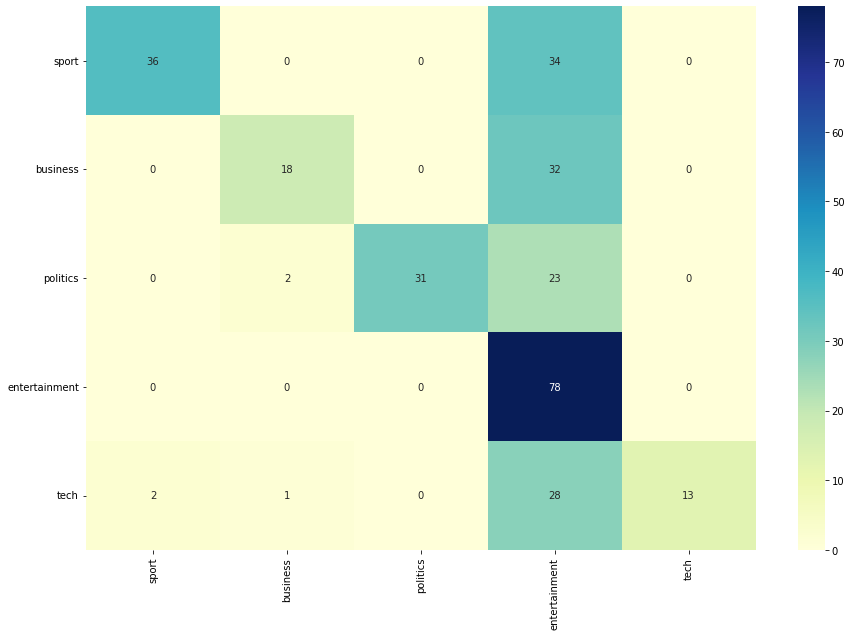

In [119]:
%matplotlib inline

conf_matrix2 = confusion_matrix(y_test, predictions2)
conf_matrix_df2 = pd.DataFrame(conf_matrix2, index=target_names, columns=target_names)

plt.figure(figsize=(15, 10))
sn.heatmap(conf_matrix_df2, annot=True, vmin=0, vmax=conf_matrix2.max(), fmt='d', cmap="YlGnBu")
plt.yticks(rotation=0)
plt.xticks(rotation=90)

Tras entrenar nuestro clasificador knn, podemos ver que ha empeorado considerablemente. 

Si analizamos la tabla de arriba, vemos que la precisión se sigue manteniendo alta en general, auque ha descendido con respecto al clasificador entrenado con Naive Bayes, es especial las noticias sobre tecnología, que se encontraban con un 100% de aciertos frente al 40% de ahora. Aún así, vemos que todos los valores de precisión salvo este se mantienen por encima del 85%, llegando al 100% en 2 casos: politicas y tecnología. En ambos el valor de precisión ha subido, mientras que en los otros 3 ha bajado. La media de precisión también ha bajado, está en torno al  84%. en cuanto a la exahustividad, los valores han descendido bastante en comparación con los obtenidos con nuestro primer clasificador. La media es de un 54% y vemos que solo se alcanza el 100% en uno de los tipos (entretenimiento). El resto están entre el 30% y el 50%. 

Al hacer la comparación general con el f1-score (que da más importancia al recall), vemos que el mejor clasificado es política, seguido de deportes, entretenimiento, negocio y, por último, tecnología. Vemos que el orden es el inverso al conseguido por el otro clasificado, a excepción de tecnología, que es el peor en ambos casos. Esto nos afirma que las noticias que más cuenta clasificar son las de tecnología.

Al ver la matriz, vemos que los fallos se producen principalmente porque se clasifican muchas noticias como entretenimiento cuando en realidad no lo son. Quitando estos fallos, el resto son muy pequeños. El fallo más destacable es el de business, donde se han clasificado casi el dobla de noticias como entretenimiento que como business.

Probablemente este fallo se debe a que, mientrass que el Naive Bayes clasifica según una probabilidad de pertenecer a un tipo u otro, el knn lo hace según el tipo de los k vecinos más cercanos, lo que hace que sea menos preciso y que los fallos se vayan acumulando.

## 3) Representación basada en word-embeddings

La segunda vectorización que vamos a usar representará los mensajes usando word-embeddings. Cada documento se representará como el vector que resulta de promediar los embeddings de cada una de sus palabras. Al igual que en el apartado anterior, usaremos monogramas y las _stop words_ que vienen configuradas por defecto para el inglés. Recuerda usar como vocabulario para vectorizar el vocabulario del fichero con las word-embeddings. 

Entrena un clasificador Naive Bayes Gaussiano (el Multinomial no admite valores negativos que sí aparecen en los embeddings). Analiza el error por clase y dibuja la matriz de confusión.

Entrena otro clasificador kNN con la nueva vectorización y la configuración por defecto y analiza su error.

In [67]:
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import KeyedVectors
glove_file = "glove.6b.50d.txt"
word2vec_file = 'glove.6B.50d.txt.word2vec'
#model = KeyedVectors.load_word2vec_format(glove_file, binary=False)
glove2word2vec(glove_file, word2vec_file)
model = KeyedVectors.load_word2vec_format(word2vec_file, binary=False)

In [129]:
x = model.most_similar(positive=['potter'], topn=5)
print(x)

[('harry', 0.7826188206672668), ('rowling', 0.7020739316940308), ('creator', 0.6936055421829224), ('book', 0.6928137540817261), ('trilogy', 0.6888231635093689)]


In [130]:
x = model.most_similar(positive=['bergman'], topn=5)
print(x)

[('ingmar', 0.8513264656066895), ('screenwriter', 0.7241118550300598), ('playwright', 0.7163271307945251), ('demme', 0.7124931216239929), ('filmmaker', 0.7065269351005554)]


In [68]:
we_vocabulary = list(model.vocab.keys())
vectorizer2 = CountVectorizer(vocabulary = we_vocabulary, binary = False, stop_words='english', token_pattern=r'(?u)\b[A-Za-z]+\b')

In [145]:
train_vector_data2 = vectorizer.fit_transform(X_train)
test_vector_data2=vectorizer.transform(X_test)

In [69]:
from sklearn.naive_bayes import GaussianNB

gnb_classifier = GaussianNB()

chunk_size=100
num_rows=len(y_train)

for i in range(0, (num_rows//chunk_size)):
    train_chunk = train_vector_data2[i*chunk_size : (i+1)*chunk_size,:].toarray()
    target_chunk = y_train[i*chunk_size : (i+1)*chunk_size]
    gnb_classifier.partial_fit(train_chunk, target_chunk, classes=np.unique(y_train))

In [70]:
# Creamos los arrays antes para ser más eficiente (crea el array grande y luego lo rellena)
gnb_train_predictions=np.zeros_like(y_train)
gnb_test_predictions=np.zeros_like(y_test)

for i in range(0, (num_rows//chunk_size)):
    train_chunk = train_vector_data2[i*chunk_size : (i+1)*chunk_size,:].toarray()
    gnb_train_predictions[i*chunk_size : (i+1)*chunk_size] = gnb_classifier.predict(train_chunk)
    
num_rows=len(y_test)
for i in range(0, (num_rows//chunk_size)):
    test_chunk = test_vector_data2[i*chunk_size : (i+1)*chunk_size,:].toarray()
    gnb_test_predictions[i*chunk_size : (i+1)*chunk_size] = gnb_classifier.predict(test_chunk)

print("Gaussian Naive Bayes, porcentaje de error en entrenamiento:", 1 - np.mean(gnb_train_predictions == y_train))
print("Gaussian Naive Bayes, porcentaje de error en test:", 1 - np.mean(gnb_test_predictions == y_test))

Gaussian Naive Bayes, porcentaje de error en entrenamiento: 0.07718120805369133
Gaussian Naive Bayes, porcentaje de error en test: 0.3791946308724832


Vemos como el porcentaje de error en entrenamiento es muy bajo, apenas llega al 1%, mientras que el de teste sube casi al 40%. Si comparamos estos con el clasificador de bolsa de palabras entrenado con Naive Bayes, nos hace pensar que probablemente será peor, aunque no mucho.

In [71]:
gnb_train_predictions2 = gnb_classifier.predict(train_vector_data2.toarray())
gnb_test_predictions2 = gnb_classifier.predict(test_vector_data2.toarray())

In [72]:
print(classification_report(y_test, gnb_test_predictions2, target_names=target_names))

               precision    recall  f1-score   support

        sport       0.96      0.91      0.93        70
     business       0.96      0.92      0.94        50
     politics       0.87      0.98      0.92        56
entertainment       0.97      0.92      0.95        78
         tech       0.89      0.93      0.91        44

     accuracy                           0.93       298
    macro avg       0.93      0.93      0.93       298
 weighted avg       0.94      0.93      0.93       298



(array([0.5, 1.5, 2.5, 3.5, 4.5]),
 [Text(0.5, 0, 'sport'),
  Text(1.5, 0, 'business'),
  Text(2.5, 0, 'politics'),
  Text(3.5, 0, 'entertainment'),
  Text(4.5, 0, 'tech')])

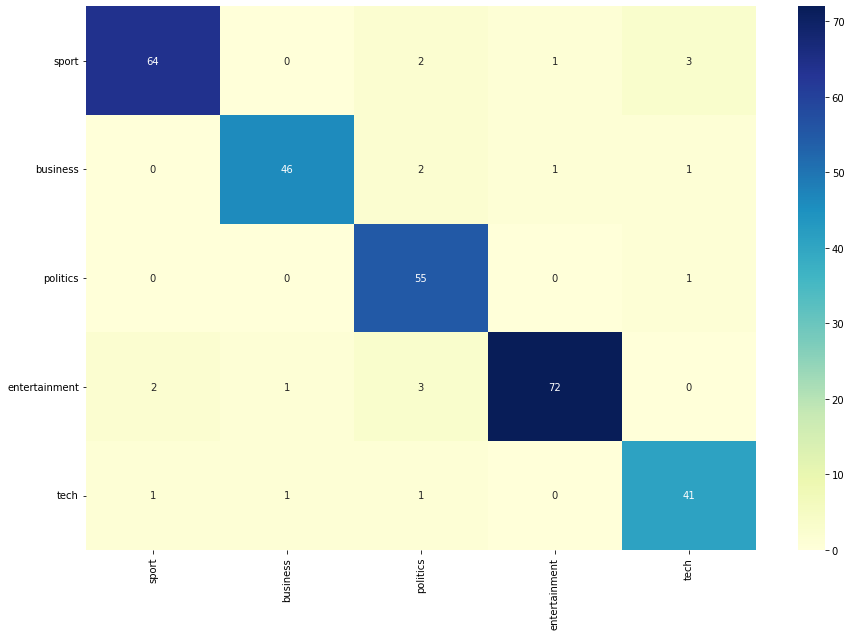

In [73]:
%matplotlib inline

classifier3=gnb_classifier
#predictions3 = gnb_test_predictions

conf_matrix3 = confusion_matrix(y_test, gnb_test_predictions2)
conf_matrix_df3 = pd.DataFrame(conf_matrix3, index=target_names, columns=target_names)

plt.figure(figsize=(15, 10))
sn.heatmap(conf_matrix_df3, annot=True, vmin=0, vmax=conf_matrix3.max(), fmt='d', cmap="YlGnBu")
plt.yticks(rotation=0)
plt.xticks(rotation=90)

Si observamos la tabla de porcentajes de clasificación, vemos como, tal como dijimos, el porcentaje de error no era muy alto. La media de la precisión es 0.92 y la del racall, 0.93, ambas altas. Sin embargo, los valores cercanos a 1 (o incluso 1) que encontrábamos al clasificar con bolsa de palabras han desaparecido y, en general, los valores han bajado, siendo los intervalos (0.89, 0.97) en la precisión y (0.91, 0.95) en la exahustividad. 

Si estudiamos el f1-score, vemos que el intervalo y la media coinciden con los de exahustividad. Estos valores tan similares nos afirman que todos los tipos de noticias se clasifican aproximadamente igual de bien. Aún así, destacaremos entretenimiento como el mejor clasificado y business y tecnología como los peores. 

Si miramos la matriz de confusión, vemos claramente esta igualdad que mencionábamos antes: Todos los elementos de la matriz tienen aproximadamente el mismo número (1 o 2), salvo la diagonal, que son los elementos bien clasificados. Esto implica que ha habido el mismo número de elementos mal clasificados con cada par de tipos (deportes clasificados como tecnología, entretenimiento, etc). De 20 malas combinacioones posibles, solo 7 no tienen 1 o 2 noticias. 5 de ellas destacan por tener valor 0. Vemos que la que menos veces ha tenido errores (más ceros en sus filas y columnas) es entretenimiento, lo que hace que sea la mejor clafificada. En cuanto a las peores clasificadas (business y tecnología), vemos que ambas se encuantran con valores de 3 en sus filas o columnas, lo que hace que su f1-score baje. Sin embargo, ya que sus valores en la matriz son muy parecidos, no destacaremos esta diferencia. 

In [74]:
knn_classifier2 = neighbors.KNeighborsClassifier()
knn_classifier2.fit(train_vector_data, y_train)

knn_train_predictions2 = knn_classifier2.predict(train_vector_data2)
knn_test_predictions2 = knn_classifier2.predict(test_vector_data2)

print("k-NN, porcentaje de error en entrenamiento:", np.mean(knn_train_predictions2 != y_train))
print("k-NN, porcentaje de error en test:", np.mean(knn_test_predictions2 != y_test))

k-NN, porcentaje de error en entrenamiento: 0.36828859060402686
k-NN, porcentaje de error en test: 0.40939597315436244


(array([0.5, 1.5, 2.5, 3.5, 4.5]),
 [Text(0.5, 0, 'sport'),
  Text(1.5, 0, 'business'),
  Text(2.5, 0, 'politics'),
  Text(3.5, 0, 'entertainment'),
  Text(4.5, 0, 'tech')])

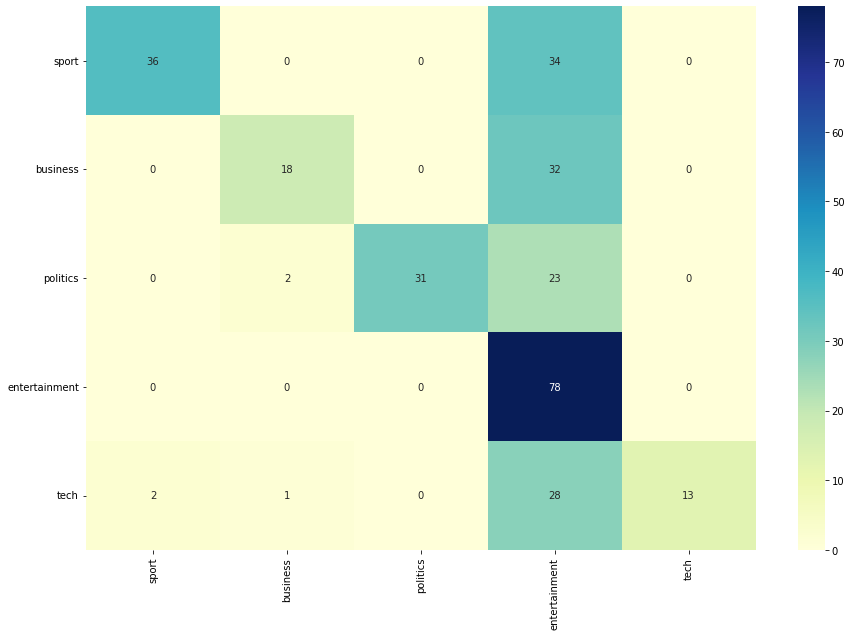

In [75]:
%matplotlib inline

classifier4=knn_classifier2
#predictions3 = gnb_test_predictions

conf_matrix4 = confusion_matrix(y_test, knn_test_predictions2)
conf_matrix_df4 = pd.DataFrame(conf_matrix4, index=target_names, columns=target_names)

plt.figure(figsize=(15, 10))
sn.heatmap(conf_matrix_df4, annot=True, vmin=0, vmax=conf_matrix4.max(), fmt='d', cmap="YlGnBu")
plt.yticks(rotation=0)
plt.xticks(rotation=90)

Aquí vemos que el porcentahe de error en test ha aumentado muy poco, por lo que podemos decir que apenas ha variado, mientras que el porcentaje de error en entrenamiento ha subido a casi un 40%, lo que nos hace pensar que será mucho peor que el clasificador entrenado por Naive Bayes.

Al observar la matriz de confusión vemos que efectivamente tiene más errores que la matriz anterior. Vemos que, al igual que pasó con el clasificador con bolsa de palabras, muchas de las notocias mal clasificadas se han confundido con entretenimiento. De hecho, esta matriz es exactamente igual que la conseguida anteriormente. Esto es posible que se deba a que el entrenamiento con knn, al seleccionar por vecinos en vez de por palabras, seleccione los mismos vecinos sin importar el método que se use para el clasificador.  

## 4) Análisis comparativo final

Hemos entrenado dos clasificadores usando dos vectorizaciones diferentes de los datos. Compara la tasa de acierto de todos ellos y explica a qué crees que se deben las diferencias.

Busca un mensaje mal clasificado por el Naive Bayes con vectorización de frecuencias y otro mal clasificado por el k-NN con Word-embeddings. Analiza los vectores de términos de dichos mensajes e intenta razonar por qué ha sido clasificado erróneamente.

Para el Naive Bayes con vectorización de frecuencias, elige dos clases donde el clasificador no haya funcionado bien y analiza las palabras más relevantes para clasificar una noticia como de dichas clases. Razona si lo que ves crees que influye en la posible confusión a la hora de clasificar entre dichas clases.

### Análisis comparativo



                           ENTRENAMIENTO           TEST

BOLSA DE PALABRAS          
   
    Naive Bayes                  0.99                0.97
   
    knn                          0.63                0.59
   
WORD EMBEDDING

    Naive Bayes                  0.93                0.63
    
    knn                          0.63                0.59

A priori esperábamos que la clasificación por word embedding funcionara mejor que la de bolsa de palabras, ya que, al tener las palabras valores que las definan pensamos que sería más óptimo a la hora de encontrar textos parecidos por sinónimos, algo que no puede hacer la bolsa de palabras, que compara las palabras en sí. Sin embargo, al ejecutar ambos algoritmos hemos visto distintos resultados. 

En cuanto a los entrenados con Naive Bayes, el basado en bolsa de palabrasobtiene mejores resultados que el el word embedding. El primero tiene una tasa de acierto en test 0.97 y entrenamiento 0.99, mientras que el segundo tiene tasas de test 0.63 y entrenamiento 0.93 (datos optenidos en partes 2 y 3). Vemos que en word embedding baja considerablemenete, en especial el porcentaje de acierto de test. Creemos que esto puede deberse a que, al buscar palabras con valores similares, encuentre otras que, aunque puedan ser sinónimos en algunos contextos, no lo sean en este, y por tanto hagan que la noticia esté mal clasificada, aunque esta misma razón es la que nos hizo pensar en un principio que word embedding sería mejor. Vemos también que el orden de tipos de noticias mejor clasificads también cambian. Esto creemos que se debe a que, al buscar según los valores de las word embedding en vez de por palabras concretas, las confusiones entre tipos de noticias también son diferentes. 

En cuanto al knn, vemos que los porcentajes coinciden en ambos casos: 0.63 en entrenamiento y 0.59 en test. Estos porcentajes con más bajos ya que, como explicamos en la parte 2, el knn es un mal método de entrenamiento para un clasificador ya que se basa en los vecinos de un individuo, en vez de dar una probabilidad como hace el Naive Bayes. Hemos comprobado también que coinciden las matrices de confusión. Esto creemos que es debido al entrenamiento por knn, ya que, como hemos dicho antes, se basa en la clasificación de los vecinos: si los vecinos son los mismos, la clasificación en ambos modelos será igual.

Como conclusión, vemos que el entrenamiento con knn es el que peor funciona con clasificadores, sin importar el modelo. EN cuanto al Naive Bayes, vemos que en este caso funciona mejor con bolsa de palabras que con word embedding.

### Mensajes mal clasificados

In [123]:
## Mensaje mal clasificado Naive Bayes con bolsa de palabras

encontrado = 0
i = 0

while encontrado == 0 and i < mnb_test_predictions.size:
    if y_test[i] != mnb_test_predictions[i]:
        encontrado = 1
    else:
        i = i + 1
    

print ("Tipo esperado: " + y_test[i])
print ("Tipo obtenido: " + mnb_test_predictions[i])
print()
write_terms(feature_names, X_test, test_vector_data, i)


Tipo esperado: tech
Tipo obtenido: business

Mensaje 58 : games maker fights for survival one of britain s largest independent game makers  argonaut games  has been put up for sale.  the london-based company behind the harry potter games has sacked about 100 employees due to a severe cash crisis. the administrators told bbc news online that selling argonaut was the only way to save it as it had run out of cash. argonaut warned that it was low on cash 10 days ago when its shares were suspended from trading on the london stock exchange.  argonaut has been making games for some 18 years and is one the largest independent games developers in the uk.  along with its headquarters in north london  it operates studios in cambridge and sheffield. argonaut was behind the harry potter games which provided a healthy flow of cash into the company. but  like all software developers  argonaut needed a constant flow of deals with publishers. signs that it was in trouble emerged in august  when it warn

Aquí vemos un mensaje de tecnología clasificado como business. Este mensaje habla sobre la venta de una compañía de creación de videojuegos, por lo que tiene sentido que sea confundida con una noticia de negocios. Vemos palabras que pueden haber causado esta confusión, como 'business', 'administrator' o 'company', que se suelen usar en un ámbito de negocios más que en uno tecnológico. Así mismo, vemos un pequeño número de palabras relacionadas con la tecnología, como'software' o 'online', que no son muy representativas. 

In [124]:
## Mensaje mal clasificado knn con word embedding
encontrado = 0
i = 0

while encontrado == 0 and i < knn_test_predictions2.size:
    if y_test[i] != knn_test_predictions2[i]:
        encontrado = 1
    else:
        i = i + 1
    

print ("Tipo esperado: " + y_test[i])
print ("Tipo obtenido: " + knn_test_predictions2[i])
print()
write_terms(feature_names, X_test, test_vector_data2, i)


Tipo esperado: tech
Tipo obtenido: sport

Mensaje 2 : us duo in first spam conviction a brother and sister in the us have been convicted of sending hundreds of thousands of unsolicited e-mail messages to aol subscribers.  it is the first criminal prosecution of internet spam distributors. jurors in virginia recommended that the man  jeremy jaynes  serve nine years in prison and that his sister  jessica degroot  be fined $7 500. they were convicted under a state law that bars the sending of bulk e-mails using fake addresses.  they will be formally sentenced next year. a third defendant  richard rutkowski  was acquitted. prosecutors said jaynes was  a snake oil salesman in a new format   using the internet to peddle useless wares  news agency associated press reported. a  fed-ex refund processor  was supposed to allow people to earn $75 an hour working from home. another item on sale was an  internet history eraser . his sister helped him process credit card payments. jaynes amassed a fo

Aquí vemos un mensaje de tecnología clasificado como deportes. Este mensaje habla sobre un envío masivo de spam a correos electrónicos. Creemos que este error se puede deber a los vecinos cercanos. Como ya dijimos antes, el knn es un mal método de entrenamiento. Vemos que la mayoría de palabras tienen relación con el tema fiscal, y unas pocas con tecnología, pero no vemos ninguna palabra representativa de deportes.

### Peores tipos de Naive Bayes multinomial

In [152]:
##Las peores son politicas y tecnologia
mnb_classifier.classes_

array(['business', 'entertainment', 'politics', 'sport', 'tech'],
      dtype='<U13')

In [154]:
##Valor de cada palabra para cada clase
mnb_classifier.feature_count_

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 4., 1., ..., 5., 0., 3.],
       [0., 0., 1., ..., 0., 0., 0.]])

In [168]:
##Calculamos el peso maximo de las palabras
i = 0
type = 2 #politica
max = 0

while i < len(feature_names):
    if mnb_classifier.feature_count_[type][i] > max:
        max =  mnb_classifier.feature_count_[type][i]
    i = i + 1

max

1175.0

In [176]:
##Consideramos palabras relevantes las que tienen peso 70 o mas
i = 0
type = 2 #politica
words = []

while i < len(feature_names):
    if mnb_classifier.feature_count_[type][i] > 70:
        words.append(feature_names[i])
    i = i + 1

print(len(words))
words

69


['added',
 'bbc',
 'believe',
 'blair',
 'britain',
 'british',
 'brown',
 'campaign',
 'chancellor',
 'children',
 'council',
 'country',
 'election',
 'eu',
 'expected',
 'foreign',
 'general',
 'government',
 'home',
 'howard',
 'issue',
 'just',
 'kennedy',
 'kilroy',
 'labour',
 'law',
 'leader',
 'lib',
 'liberal',
 'local',
 'lord',
 'make',
 'michael',
 'minister',
 'mps',
 'mr',
 'new',
 'news',
 'parties',
 'party',
 'people',
 'plans',
 'police',
 'political',
 'prime',
 'public',
 's',
 'said',
 'say',
 'saying',
 'says',
 'secretary',
 'spokesman',
 't',
 'tax',
 'time',
 'told',
 'tony',
 'tories',
 'tory',
 'uk',
 'ukip',
 'vote',
 'want',
 'way',
 'week',
 'work',
 'year',
 'years']

En la clase politica podemos ver las 69 palabras más relevantes que describen a esta clase, entre las que destacamos 'vote', 'political', liberal' o 'government'. Estas palabras son muy representativas de esta clase. Vemos algunas palabras que pueden causra confusión, como l'leader', que podría aparecer en temas tecnológicos de videojuegos, o 'police'. Destacamos sobre todo 'party' por su doble significado: fiesta y partido, que pueden causar confusión en algunos casos. También vemos palabras muy generales que podrían usarse en cualquier contexto, como 'just', 'make' o year'.

In [177]:
##Calculamos el peso maximo de las palabras
i = 0
type = 4 #tecnologia
max = 0

while i < len(feature_names):
    if mnb_classifier.feature_count_[type][i] > max:
        max =  mnb_classifier.feature_count_[type][i]
    i = i + 1

max

865.0

In [179]:
##Consideramos palabras relevantes las que tienen peso 70 o mas
i = 0
type = 4 #tecnologia
words = []

while i < len(feature_names):
    if mnb_classifier.feature_count_[type][i] > 70:
        words.append(feature_names[i])
    i = i + 1
    
print(len(words))
words

94


['able',
 'according',
 'apple',
 'based',
 'bbc',
 'broadband',
 'called',
 'companies',
 'computer',
 'consumer',
 'consumers',
 'content',
 'data',
 'devices',
 'different',
 'digital',
 'e',
 'end',
 'europe',
 'firm',
 'firms',
 'gadget',
 'gadgets',
 'game',
 'games',
 'gaming',
 'going',
 'help',
 'high',
 'home',
 'information',
 'internet',
 'just',
 'like',
 'mail',
 'make',
 'market',
 'media',
 'messages',
 'microsoft',
 'million',
 'mobile',
 'mobiles',
 'months',
 'mr',
 'music',
 'net',
 'network',
 'networks',
 'new',
 'news',
 'number',
 'online',
 'pc',
 'people',
 'phone',
 'phones',
 'players',
 'radio',
 'report',
 'research',
 's',
 'said',
 'says',
 'search',
 'security',
 'service',
 'services',
 'set',
 'site',
 'sites',
 'software',
 'sony',
 'spam',
 't',
 'technology',
 'time',
 'tv',
 'uk',
 'use',
 'used',
 'users',
 'using',
 'video',
 'virus',
 'want',
 'way',
 'web',
 'website',
 'websites',
 'work',
 'world',
 'year',
 'years']

Primero destacamos que el peso máximo es menor que en políticas y que, al seleccionar las palabras más relevantes con peso 70 o más salen más palabras que con el tipo anterior. Esto creemos que da como resultado que haya más confusión que con otras clases. Destacamos palabras como 'software', 'online' o 'gaming' como características de esta clase. Vemos las mismas palabras generales, 'just', 'make' y 'year', que vimos en la clase políticas, que podrían dar confusión entre los tipos a la hora de clasificarlos. También vemos nombres de marcas, como 'microsoft', 'apple' y 'sony', que podrían ser usadas en noticias de business, palabras como 'music' y 'tv', que se usan en noticias de entretenimiento y 'player', que podria referirse a deportes. Podemos ver en esta lista por qué esta clase es la peor, ya que sus palabras relevantes pueden ser confundidas con cualquiera de las otrs clases.